According to a study by Pear Analytics [16], about 40% of all the tweets are pointless “babbles” like “have to get something from the minimart downstairs”

In [1]:
import pickle
from os import path
import re
from nltk.tokenize import TweetTokenizer
import nltk
import csv
import numpy as np
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
import CMUTweetTagger
from sklearn.metrics.pairwise import pairwise_distances
import scipy.cluster.hierarchy as sch
import fastcluster
from collections import Counter
import codecs
from datetime import datetime
from glob import glob
import pandas as pd
import sys
import langid
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
%matplotlib inline

In [2]:
DIR_DATA = path.join('data', 'twitter data1')
DIR_GEO = path.join('data', 'geofiles')

# Read the file
## First run the Preprocesseing_Event2 code and choose the slot you want to give to algorithm for event detection

In [ ]:
# Loading the saved file is as easy as running these lines of code
i = 9 # Choose the appropriate chunk of dataframe
with open('data/twitter data/'+str(i)+'clean_data_event.pkl', 'rb') as in_file:
    df = pickle.load(in_file)

In [ ]:
# Choose the english tweets
df = df[df['language']=='en']
df.reset_index(drop=True,inplace = True)

In [ ]:
# Add some columns for further analysis
df['day'] = df['createdAt'].map(lambda x: x.day)
df['month'] = df['createdAt'].map(lambda x: x.month)
df['year'] = df['createdAt'].map(lambda x: x.year)
daily_user = ['userId', 'year', 'month', 'day']
df['daily_tweets'] = df.groupby(by=daily_user)['userId'].transform('count')

** Note that the text of these files are already preprocessed in the Preprocessing_Event.ipy code**

# Preprocessing

In [10]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

According to our search in the literutre we found that stemming is not that helpful, in the case one want ot do stemming, first he should detect the language (for example by langdetect package) and then use the stemmer developed for that language

# Build the clustering algorithm, 
Now we are ready to build the clustering algorithm.

In [11]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [35]:
def scipy_distance(p, q):
    return cdist(p, q)
def find_title(df,tfidf_matrix):
    ## The function recieves the tf idf and returns 
    # a title representing the cluster
    # We find the closest text to the centroid of the cluster
    clusters = df['cluster'].max()
    for c in range(clusters+1):
        indices = df['cluster']==c
        text = df[indices]['text']
        text.reset_index(drop=True,inplace=True)
        tfs = tfidf_matrix[indices.values,:]
        if tfs[0,:].sum() ==0:
            continue
        centroid = np.mean(tfs,axis=0)
        title = text[scipy_distance(centroid, tfs).argmin()]
        print(c,title)

In [74]:
def clusterer(df_temp):
    # Calculate the tfidf of the processed text
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, max_features=200000,
                                     min_df= 0.03, stop_words='english',
                                     use_idf=True, ngram_range=(1,3)) # , tokenizer=tokenize_only

    tfidf_matrix = tfidf_vectorizer.fit_transform(df_temp['processed_text']) #fit the vectorizer to synopses

    print('Shape of the tfidf',tfidf_matrix.shape)
    tfidf = tfidf_matrix.todense() # convert the sparse tfid_matrix to a dense one
    terms = tfidf_vectorizer.get_feature_names() # some possible features for being a stopword
    print(terms)
    # calculate the distance metric used for clustering
    #dist = 1 - cosine_similarity(tfidf_matrix)
    num_clusters = 3

    km = KMeans(n_clusters=num_clusters)

    km.fit(tfidf_matrix)

    clusters = km.labels_.tolist()
    #df_temp['cluster'] = np.nan
    df_temp['cluster'] = clusters
    find_title(df_temp,tfidf)
    return df_temp

In [75]:
def wordcloud_plotter(df_temp,cluster_id):
    # The function plots the wordcloud of a cluster
    raw_text = ' '.join(df_temp[df_temp['cluster']== cluster_id]['processed_text'].tolist())
    # Tokenize the text
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    token_text = tokenizer.tokenize(raw_text)
    # Count the number of occurance of most common words in the text
    result = Counter(token_text).most_common()
    # Plot the word cloud
    wordcloud = WordCloud().generate_from_frequencies(result)
    plt.imshow(wordcloud)
    plt.axis("off")

# Some of the events detected by the clustering algorithm
One interesting point in our algorithm is, the large clusters usually does not correspond to interesting events,
the reason might be that all the tweets who does not fall into a meaningful cluster falls in the big clusters.
The data contains some tweets about the Weather prediction, which naturally from one of the clusters. We remove those tweets to get more event type clusters. 



## When the data at time 2016.01.01 passed to the algorithm it return the new year event.

Happy new year! This is gonna be a year full of new projects and new challenges to overcome!



In [272]:
# This part of the data corresponds to the 2016.01.01
df_temp = df.iloc[:10000].copy()
df_temp.reset_index(drop=True,inplace=True)
df_temp= clusterer(df_temp)

Shape of the tfidf (10000, 13)
1 @jenniferstano is this a throw back? Nooooooooo! My love. @ Gstaad https://t.co/oYvuywlNYv
2 Happy new year! This is gonna be a year full of new projects and new challenges to overcome!… https://t.co/CXIPgikGPC


Another common cluster which happens oftenly is a cluster which contains tweets about love and flirting!!!!!.

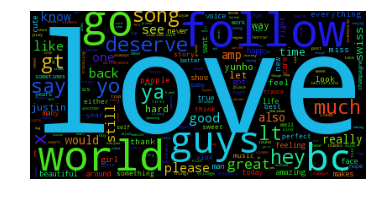

In [211]:
wordcloud_plotter(df_temp,2)

## Brexit vote

In [276]:
# This part of the data corresponds to the 2016.06.23 where Brexit happened
df_temp = df.iloc[310000:320000].copy()
df_temp.reset_index(drop=True,inplace=True)
df_temp= clusterer(df_temp)

Shape of the tfidf (10000, 6)
1 Positive opinions about the trip so far: "it's good!" (Eliza), "I like it more than I like my bed!" (Rhiannon) and "I'm buzzing!" (Rebakah)
2 RT @colebrax Chow Yun-Fat &amp; director Ang Lee at work on 'Crouching Tiger, Hidden Dragon' (2000). https://t.co/2FIRvUmNw8


The returened title does not show anything about the Brexit, however in the wordcloud we can clearly see the cluster finds something about Brexit, for example the words like Eu, uk, Vote, people.

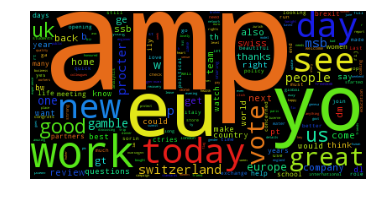

In [275]:
wordcloud_plotter(df_temp,1)

## 2016.02.26

In [311]:
# This part of the data corresponds to the 2016.02.26
df_temp = df.iloc[90000:102000].copy()
df_temp.reset_index(drop=True,inplace=True)
df_temp= clusterer(df_temp)

Shape of the tfidf (12000, 9)
1 Celebrate 5th anniversary of the @UNOrchestra at the Victoria Hall in Geneva on 13 March - https://t.co/pc5UItrNnk https://t.co/Gm0tgK7eNT
2 Preview Baselworld 2016 Meccaniche Veloci ICON CaféRacer, a 4 GMT equipped with the new in-house… https://t.co/jkAG1S3JZ4
3 costco pizza is actually in like top 3 fr
4 #CEDAW queries impact of MNCs taking over land,when decisions made to buy/ lease land were women heard?Compensation&amp;resettlement? #Tanzania


**The second cluster points to an opera show in Geneve**

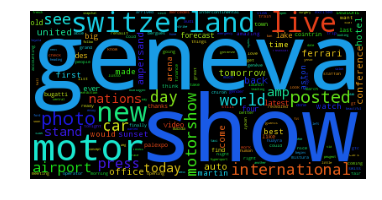

In [313]:
wordcloud_plotter(df_temp,2)

In [80]:
# This part of the data corresponds to the 
df_temp = df.iloc[485000:492000].copy()
df_temp.reset_index(drop=True,inplace=True)
df_temp= clusterer(df_temp)

Shape of the tfidf (7000, 4)
['amp', 'day', 'photo', 'switzerland']
1 #interlaken @ Interlaken, Switzerland https://t.co/Brjepl36NI
2 Great house decoration ready for @letapedutour &amp; @leTourdeFranz the local people doing their… https://t.co/T3kEHtZy73


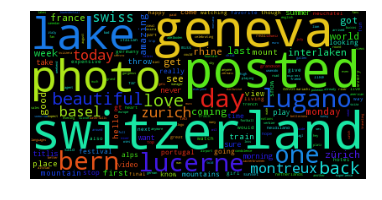

In [73]:
wordcloud_plotter(df_temp,1)